code adapted from https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

In [26]:
# Import standard data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('ggplot')

# Import NLP libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download necessary datasets for nltk
nltk.download('punkt')          # Tokenizers
nltk.download('vader_lexicon')  # Lexicon for Sentiment Analysis

# Import progress bar utility
from tqdm.notebook import tqdm

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
pip install --upgrade transformers

In [28]:
from transformers import pipeline

# Define the model path
model_path = "cardiffnlp/twitter-roberta-base-sentiment"

# Load the sentiment analysis pipeline
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Perform sentiment analysis
result = sentiment_task("Covid cases are increasing fast!")

print(result)

[{'label': 'LABEL_1', 'score': 0.5822070240974426}]


In [29]:
# Read in data
df = pd.read_csv('/content/drive/MyDrive/CAPSTONE PROJECT LG/labelled_dataset_cleaned.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(5001, 6)
(500, 6)


In [30]:
df.head()

,link_id,parent_id,User,Text,Intent,Support
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,i,i
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",u,u
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",u,n
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent DD posted? 9 billion in re...,u,u
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,y,u


In [31]:
df.shape

(500, 6)

In [32]:
df[df['Text'].isna()]

,link_id,parent_id,User,Text,Intent,Support


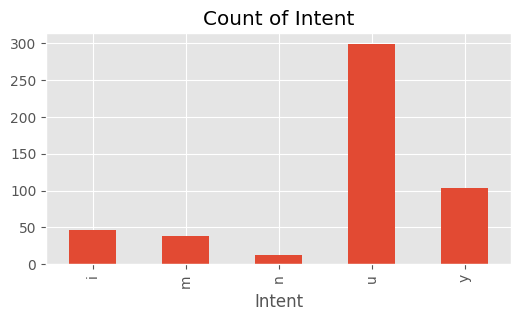

In [33]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(6, 3))
ax.set_xlabel('Intent')
plt.show()

In [34]:
example = df['Text'][50]
print(example)

WTF I was charging getting in this post. Apparently we all here apes that just love GME stonk!

I am HOLDing and planning to tell the story of 💎🙌 to next generations of retards 🙃


In [35]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [36]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [37]:
# VADER results on example
print(example)
sia.polarity_scores(example)

WTF I was charging getting in this post. Apparently we all here apes that just love GME stonk!

I am HOLDing and planning to tell the story of 💎🙌 to next generations of retards 🙃


{'neg': 0.124, 'neu': 0.769, 'pos': 0.108, 'compound': -0.1593}

In [38]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.22853346, 'roberta_neu': 0.46110365, 'roberta_pos': 0.31036294}


In [39]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [40]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['link_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id t3_l70sjp
Broke for id t3_l856qs
Broke for id t3_l74zgc


In [41]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'link_id'})
results_df = results_df.merge(df, how='left')

In [42]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   link_id         500 non-null    object 
 1   vader_neg       500 non-null    float64
 2   vader_neu       500 non-null    float64
 3   vader_pos       500 non-null    float64
 4   vader_compound  500 non-null    float64
 5   roberta_neg     500 non-null    float64
 6   roberta_neu     500 non-null    float64
 7   roberta_pos     500 non-null    float64
 8   parent_id       500 non-null    object 
 9   User            500 non-null    object 
 10  Text            500 non-null    object 
 11  Intent          500 non-null    object 
 12  Support         500 non-null    object 
dtypes: float64(7), object(6)
memory usage: 54.7+ KB


In [43]:
# Checking the value counts again
value_counts = results_df['Intent'].value_counts()
print(value_counts)

u    299
y    103
i     47
m     39
n     12
Name: Intent, dtype: int64


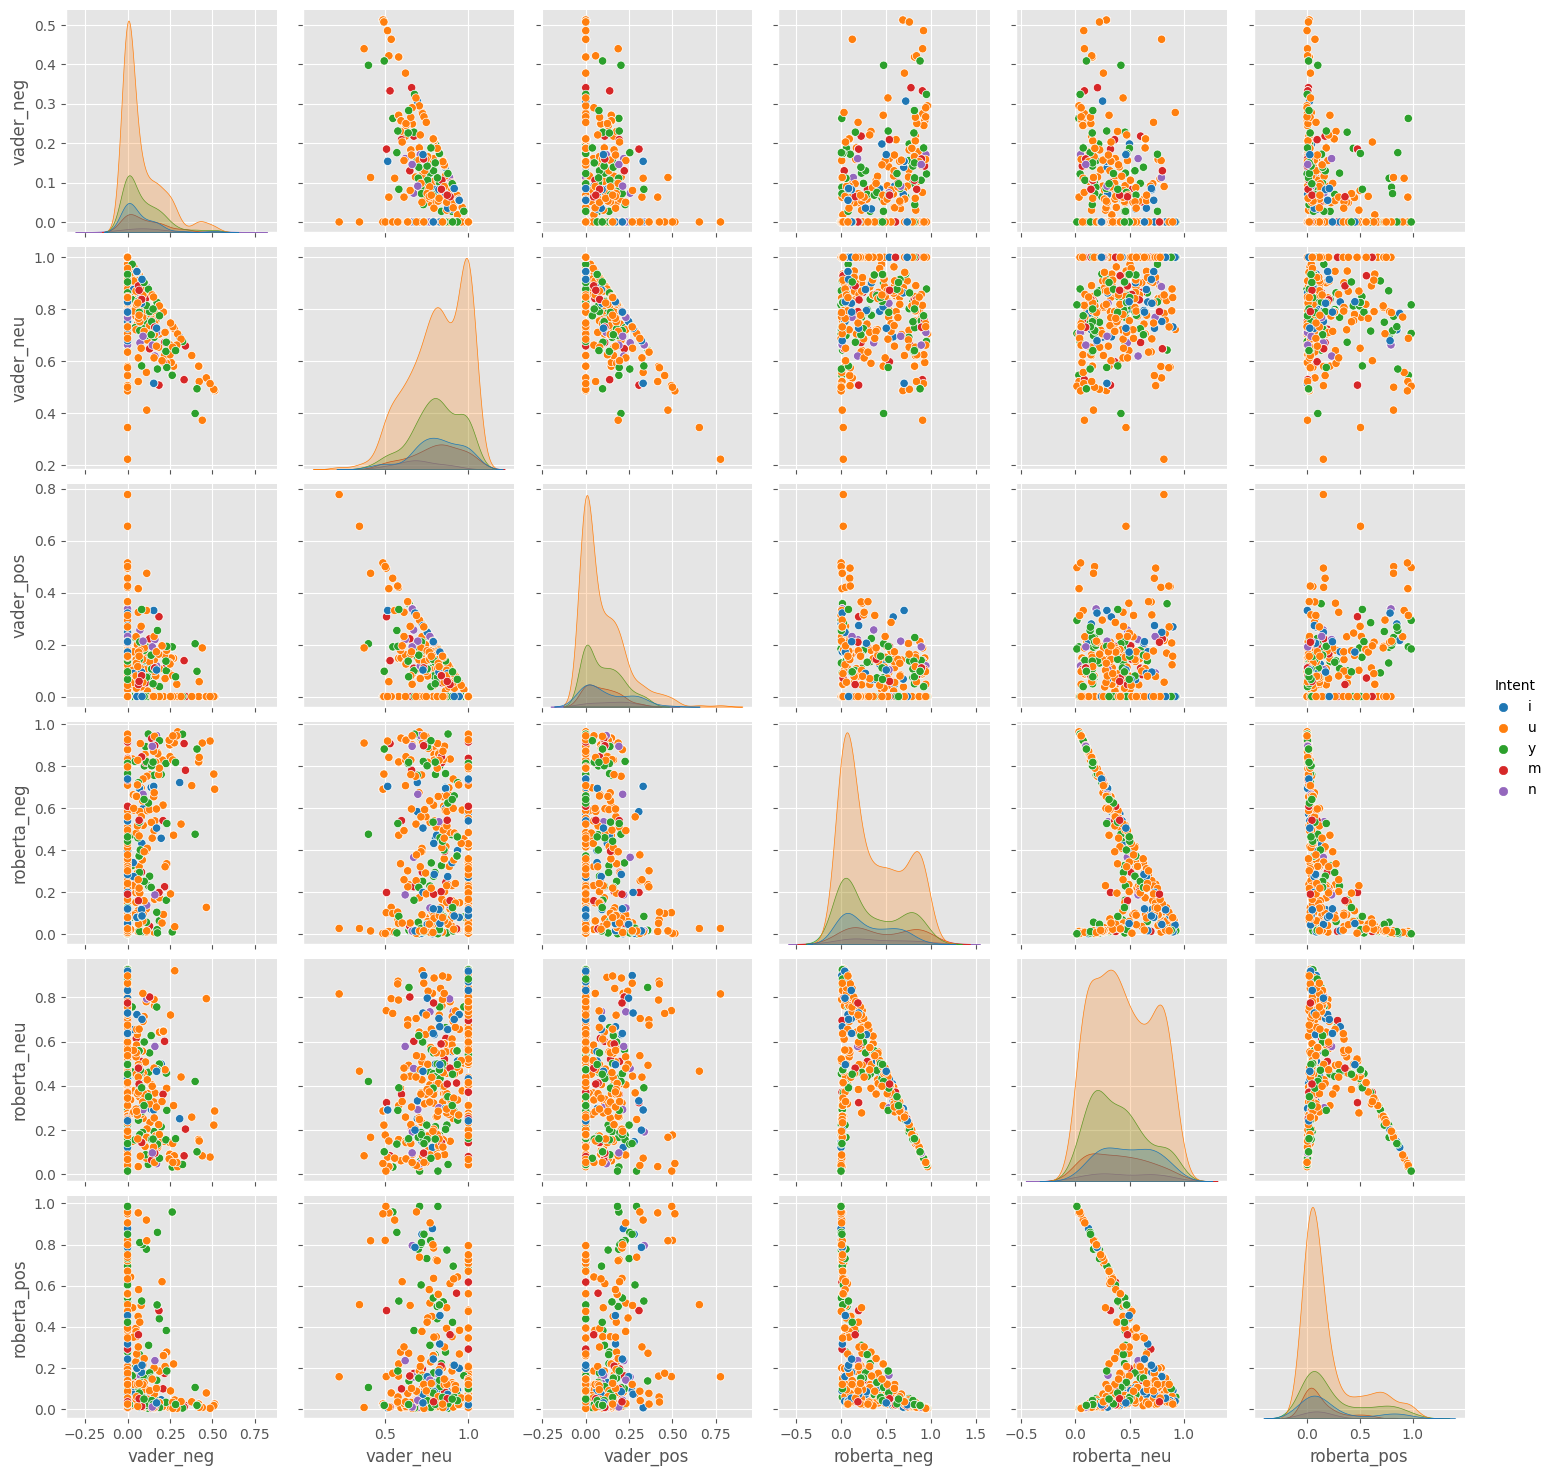

In [44]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Intent',
            palette='tab10')
plt.show()

Examples of positive sentiment identified correctly:

In [45]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"Good morning fellow retards. Denmark checking in, ready to buy more $GME stock at open. I just want to say I really appreciate each and everyone of you wonderful people out there! Stay hydrated, you'll need it for the \n🧑\u200d🚀🚀🚀🚀🚀🚀🚀🌌🌌🌌🌌"

In [46]:
results_df.query('Intent == "y"') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'I have a confession to make:\nI sold my BB shares today...\nBut, I used all the money to buy more GME'

Examples of negative sentiment identified correctly:

In [47]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[1]

'Exactly, oh well people thumbing this shit down just want to pump their bags and cash out on call premiums convincing people to buy them because”SQUEEZE WILL HAPPEN ANY DAY NOW GME $1000”. I feel bad, but mehhhhh, as more people blow up their accounts I hope a large chunk of them think twice about buying into a dead play. Oh well'

In [48]:
results_df.query('Intent == "n"') \
    .sort_values('vader_neg', ascending=False)['Text'].values[1]

"PLEASE DON'T BE SMART AND SELL GME"

Below are examples of misclassifications:

In [49]:
results_df.query('Intent == "y"') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'REVOLUT will NOT allow me to buy GME. TAKE IT OFF THE LIST'

In [50]:
results_df.query('Intent == "n"') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I honestly feel like one of those people that was on the Netflix doc about cults. Looking back on all the posts that gave me hope on GME... wow.'

In [51]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [52]:
sent_pipeline('Exactly, oh well people thumbing this shit down just want to pump their bags and cash out on call premiums convincing people to buy them because”SQUEEZE WILL HAPPEN ANY DAY NOW GME $1000”. I feel bad, but mehhhhh, as more people blow up their accounts I hope a large chunk of them think twice about buying into a dead play. Oh well')

[{'label': 'NEGATIVE', 'score': 0.9977630376815796}]

In [53]:
sent_pipeline("PLEASE DON'T BE SMART AND SELL GME")

[{'label': 'NEGATIVE', 'score': 0.9995328187942505}]

In [54]:
sent_pipeline("PLEASE DON'T BE SMART AND BUY GME")

[{'label': 'NEGATIVE', 'score': 0.9993476271629333}]

In [55]:
sent_pipeline("only loosers would sell gamestop")

[{'label': 'NEGATIVE', 'score': 0.9728074073791504}]

In [56]:
sent_pipeline("only loosers would buy gamestop")

[{'label': 'NEGATIVE', 'score': 0.9890826940536499}]

In [57]:
sent_pipeline("🚀🚀🚀🚀🚀🚀🚀")

[{'label': 'NEGATIVE', 'score': 0.6970565319061279}]

In [58]:
sent_pipeline("🌙")

[{'label': 'NEGATIVE', 'score': 0.6970565319061279}]

In [59]:
sent_pipeline("💎🙌")

[{'label': 'NEGATIVE', 'score': 0.6970565319061279}]

In [60]:
sent_pipeline("apes 🦍")

[{'label': 'NEGATIVE', 'score': 0.7105834484100342}]

In [ ]:
sent_pipeline("WE ARE PLUS 430!!! 🌙  🦍 WE ARE DOING IT. NOW KEEP HOLDING AND DONT GIVE INTO WHAT THEY WANT. IT WILL BE 600 BEFORE THE DAYS OUT AND THEN MONDAY IT WILL OPEN AT $1000 🤞 IF NOT THEN JUST A LITTLE LESS. BUY BUY BUY PEOPLE THIS IS STILL ONLY THE BEGINNING!!! AND DONT SELL WHEN YOU SEE THE DROP THIS MORNING THIS IS WHAT THEY WANT YOU TO DO AND THEN THEY WILL MAKE IT SO YOU CAN BUY ANYMORE STOCKS OR GAME STOP LIKE THEY DONE YESTERDAY BUT WE ARE NOT STUPID!! HOLDING AND NOT SELLING AND BUYING MORE HERE WHEN LAME ASS ROBINHOOD OPENS. HOLD HOLD HOLD. TO THE MOON🚀🚀🚀🚀🚀🚀🚀")

In [62]:
# Recording the cleaned dataset as a new csv file to be used in future:
# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/CAPSTONE PROJECT LG/labelled_dataset_postNLP.csv', index=False)